In [ ]:
# ==========================================
# BLOQUE 1: CONFIGURACIÓN E INSTALACIÓN
# ==========================================
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import shutil

%pip install opencv-python-headless matplotlib numpy

print("Entorno configurado.")

Note: you may need to restart the kernel to use updated packages.
Entorno configurado.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# ==========================================
# BLOQUE 2: CONFIGURACIÓN DE DATOS LOCALES (SIMPLIFICADO)
# ==========================================
from pathlib import Path

# Definimos directamente las rutas donde has subido tus archivos
# (Asegúrate de que los nombres de las carpetas coinciden exactamente con los que creaste)
img_path = Path("mis_datos/images")
mask_path = Path("mis_datos/masks")

print(f"Ruta de imágenes configurada: {img_path}")
print(f"Ruta de máscaras configurada: {mask_path}")

# --- VALIDACIÓN RÁPIDA ---
# Comprobamos si las carpetas existen y tienen cosas dentro
if not img_path.exists() or not mask_path.exists():
    print("ERROR: No encuentro las carpetas 'mis_datos/images' o 'mis_datos/masks'.")
    print("   Asegúrate de haber creado las carpetas y subido los archivos.")
else:
    num_imgs = len(list(img_path.glob("*")))
    num_masks = len(list(mask_path.glob("*")))
    
    print(f"Encontradas {num_imgs} imágenes.")
    print(f"Encontradas {num_masks} máscaras.")
    
    if num_imgs == 0:
        print(" CUIDADO: La carpeta de imágenes está vacía.")
    elif num_imgs != num_masks:
        print(f"AVISO: Tienes {num_imgs} fotos pero {num_masks} máscaras. Debería haber el mismo número.")
    else:
        print("¡Todo perfecto! Tienes el mismo número de fotos y máscaras.")

Ruta de imágenes configurada: mis_datos\images
Ruta de máscaras configurada: mis_datos\masks
Encontradas 4 imágenes.
Encontradas 4 máscaras.
¡Todo perfecto! Tienes el mismo número de fotos y máscaras.


In [12]:
# ==========================================
# BLOQUE 3: ANÁLISIS VISUAL ROBUSTO (ACTUALIZADO)
# ==========================================

# Definición de colores para las clases (igual que antes)
class_colors = {
    0: [0, 0, 0],       # Background
    1: [128, 0, 0],     # Water
    2: [0, 128, 0],     # Building No Damage
    3: [128, 128, 0],   # Building Minor
    4: [0, 0, 128],     # Building Major
    5: [128, 0, 128],   # Building Collapsed
    6: [0, 128, 128],   # Road Clear (Cian)
    7: [128, 128, 128], # Road Blocked (Gris)
    8: [64, 0, 0],      # Vehicle (Rojo oscuro)
    9: [192, 0, 0],     # Tree
    10: [64, 128, 0]    # Pool
}

def visualizar_muestra(img_file):
    # 1. Cargar Imagen Original
    img = cv2.imread(str(img_file))
    if img is None:
        print(f"Error al leer la imagen: {img_file}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 2. Búsqueda Inteligente de la Máscara
    # Buscamos cualquier archivo en la carpeta masks que empiece con el mismo nombre
    # (independientemente de si es .png, .jpg o tiene un sufijo)
    nombre_base = img_file.stem  # Ej: "10794"
    candidatos = list(mask_path.glob(f"{nombre_base}*"))
    
    mask_file = None
    if len(candidatos) > 0:
        # Priorizamos .png si hay varios, si no, cogemos el primero que haya
        for c in candidatos:
            if c.suffix == '.png':
                mask_file = c
                break
        if mask_file is None:
            mask_file = candidatos[0]
            
    if mask_file is None or not mask_file.exists():
        print(f"ERROR: No encuentro pareja para {img_file.name}")
        print(f"   (Buscaba algo parecido a '{nombre_base}' en {mask_path})")
        print("   Archivos disponibles en masks:", [f.name for f in mask_path.glob("*")][:5], "...")
        return

    print(f"Pareja encontrada: {img_file.name} <--> {mask_file.name}")

    # 3. Cargar Máscara
    # Intentamos cargarla tal cual (IMREAD_UNCHANGED por si es indexada)
    mask = cv2.imread(str(mask_file), cv2.IMREAD_UNCHANGED)
    
    if mask is None:
        print(f"Error: El archivo {mask_file.name} existe pero no se pudo leer como imagen.")
        return

    # Si la máscara tiene 3 canales (RGB) en lugar de 1, la convertimos a escala de grises o tomamos un canal
    # RescueNet a veces da máscaras RGB donde (R=G=B=Id_Clase)
    if len(mask.shape) == 3:
        mask = mask[:, :, 0] # Nos quedamos con un solo canal

    # 4. Crear imagen de segmentación coloreada
    seg_img = np.zeros_like(img)
    unique_classes = np.unique(mask)
    
    print(f"\nAnálisis Detallado:")
    print(f"   Clases detectadas (IDs): {unique_classes}")
    
    # Pintar la máscara
    for cls_id in unique_classes:
        if cls_id in class_colors:
            color = class_colors[cls_id]
            seg_img[mask == cls_id] = color
            
            nombre_clase = "DESCONOCIDA"
            if cls_id == 1: nombre_clase = "AGUA"
            if cls_id == 2: nombre_clase = "EDIFICIO NO DAÑADO"
            if cls_id == 3: nombre_clase = "EDIFICIO DAÑADO"
            if cls_id == 4: nombre_clase = "EDIFICIO MAJOR"
            if cls_id == 5: nombre_clase = "EDIFICIO COLAPSADO" 
            if cls_id == 6: nombre_clase = "CALLE LIBRE"
            if cls_id == 7: nombre_clase = "CALLE BLOQUEADA"
            if cls_id == 8: nombre_clase = "VEHICULO"
            if cls_id == 9: nombre_clase = "ARBOL"
            if cls_id == 10: nombre_clase = "PISCINA"
            if cls_id > 0: # Ignoramos el log del fondo (0) para no ensuciar
                print(f"   -> Clase {cls_id}: {nombre_clase}")

    # Superposición
    overlay = cv2.addWeighted(img, 0.6, seg_img, 0.4, 0)

    # Plotting
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 3, 1)
    plt.title(f"Imagen: {img_file.name}")
    plt.imshow(img)
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.title(f"Máscara: {mask_file.name}")
    plt.imshow(seg_img)
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.title("Superposición")
    plt.imshow(overlay)
    plt.axis('off')
    
    plt.show()

Pareja encontrada: 10794.jpg <--> 10794_lab.png

Análisis Detallado:
   Clases detectadas (IDs): [0 5 8 9]
   -> Clase 5: EDIFICIO COLAPSADO
   -> Clase 8: VEHICULO
   -> Clase 9: ARBOL


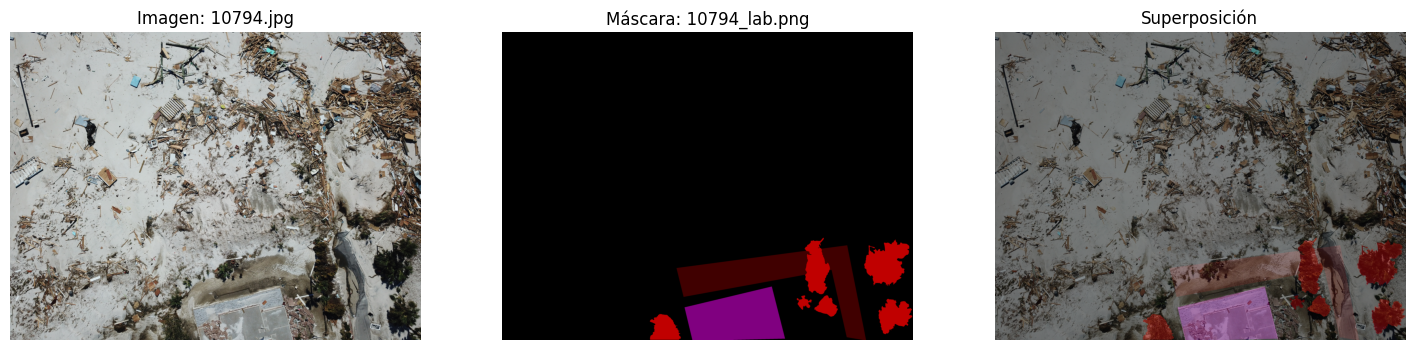

Pareja encontrada: 10801.jpg <--> 10801_lab.png

Análisis Detallado:
   Clases detectadas (IDs): [0 4 5 8 9]
   -> Clase 4: EDIFICIO MAJOR
   -> Clase 5: EDIFICIO COLAPSADO
   -> Clase 8: VEHICULO
   -> Clase 9: ARBOL


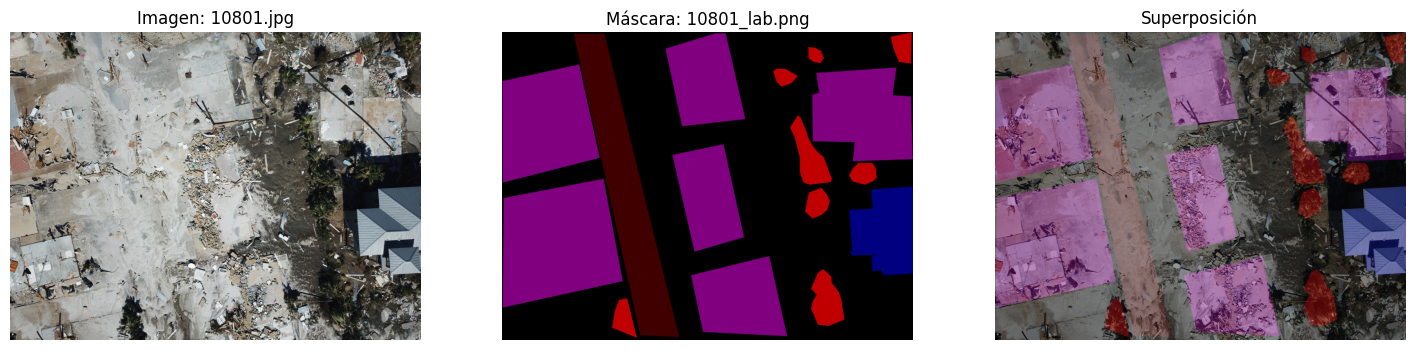

Pareja encontrada: 10807.jpg <--> 10807_lab.png

Análisis Detallado:
   Clases detectadas (IDs): [0 5 7 8 9]
   -> Clase 5: EDIFICIO COLAPSADO
   -> Clase 7: CALLE BLOQUEADA
   -> Clase 8: VEHICULO
   -> Clase 9: ARBOL


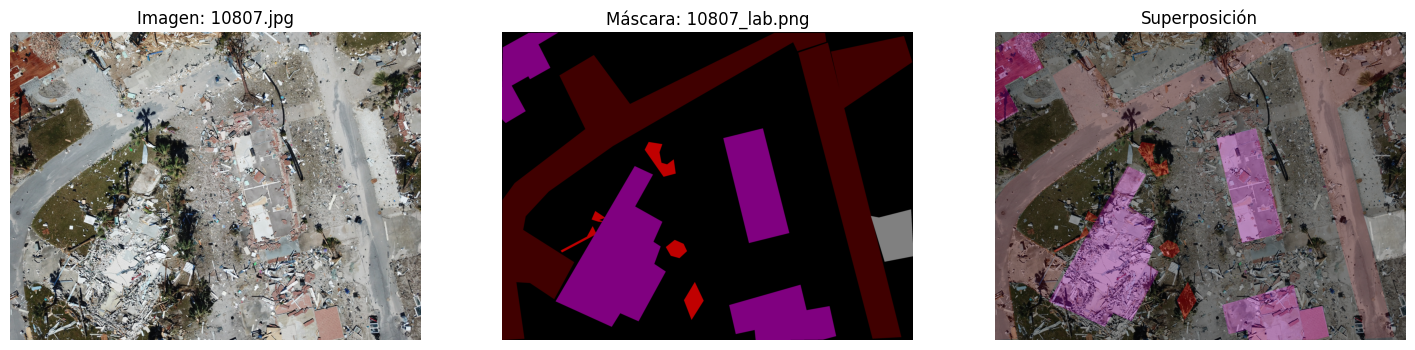

In [13]:
# ==========================================
# BLOQUE 4: EJECUCIÓN
# ==========================================
# Tomamos 3 imágenes aleatorias de la carpeta
files = list(img_path.glob("*.jpg")) + list(img_path.glob("*.png"))
if len(files) > 0:
    # Analizamos las primeras 3
    for f in files[:3]:
        visualizar_muestra(f)
else:
    print("No hay imágenes para analizar.")